In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
import os

# Print current working directory to confirm
print("Current working directory:", os.getcwd())

# Load the CSV with the correct relative path
HB_NORTH_DATA = pd.read_csv("Data/ERCOT SPPS/All_HB_NORTH_Data.csv")

# Proceed with your processing
HB_NORTH_DATA['Datetime'] = pd.to_datetime(HB_NORTH_DATA['Delivery Date']) + pd.to_timedelta(HB_NORTH_DATA['Delivery Hour'] - 1, unit='h')
HB_NORTH_DATA.set_index('Datetime', inplace=True)

daily_data = HB_NORTH_DATA['Settlement Point Price'].resample('D').mean()
print(daily_data.head())  # Check the first few rows

Current working directory: c:\Users\mgray\OneDrive\Documents\PSTAT 174\Final Project\174-Final-Project
Datetime
2015-01-01    25.211667
2015-01-02    24.488125
2015-01-03    22.963542
2015-01-04    21.648542
2015-01-05    20.929792
Freq: D, Name: Settlement Point Price, dtype: float64



=== ADF Test for Original Series ===
p-value: 1.225056305418897e-26,
 Because the p-value is less than 0.05 we know our data is stationary


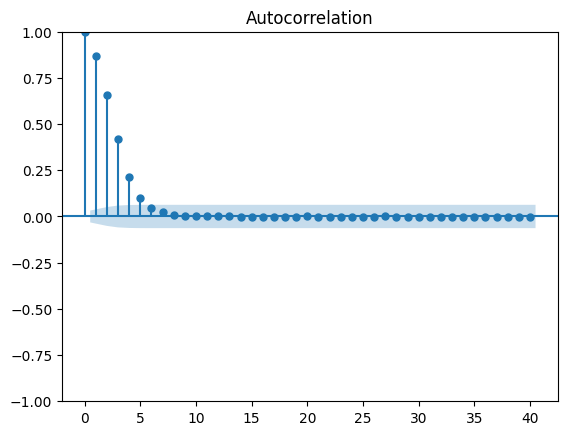

Figure(640x480)


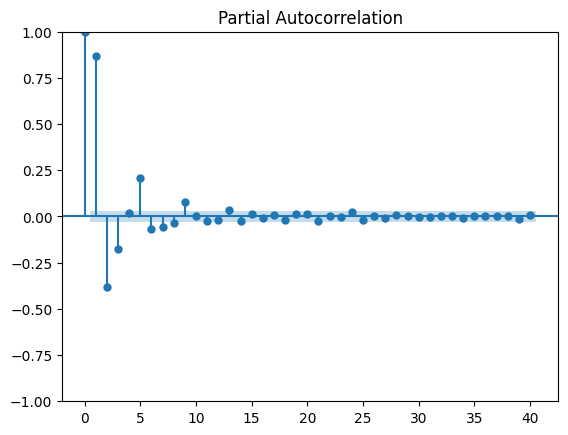

In [29]:
### Run ADF test on original series
print("\n=== ADF Test for Original Series ===")
result = adfuller(daily_data.dropna())
print(f'p-value: {result[1]},\n Because the p-value is less than 0.05 we know our data is stationary')

### Plot ACF and PACF
ACF_Plot = plot_acf(daily_data, lags=40)
plt.show()
PACF_Plot = plot_pacf(daily_data, lags=40)
print(PACF_Plot)  # Note: This prints the figure object; remove this line if not needed
plt.show()

Based on the ACF and PACF plots, the time series exhibits characteristics of an autoregressive process
with significant autocorrelation at short lags but no clear seasonal patterns. The stationary nature of
the data (confirmed by the ADF test with p-value < 0.05) suggests no differencing is needed, while the
PACF showing significant spikes at lags 1 and 2 indicates an AR(1) or AR(2) model would be appropriate.
The gradually decaying ACF pattern with no significant spikes in higher lags suggests minimal or no moving 
average components are needed, pointing toward a SARIMA model with parameters around (1-2,0,0-1)(0,0,0)7. 
Multiple candidate models should be tested and compared using information criteria and forecast
accuracy metrics to determine the optimal specification for the electricity price data. The evidence 
most strongly supports a simple AR process rather than a complex seasonal model, though weak weekly 
seasonality could be explored if domain knowledge suggests it might exist.

In [30]:
# Candidate models
candidate_models = [
    ((1, 0, 0), (0, 0, 0, 7)),  # AR(1)
    ((2, 0, 0), (0, 0, 0, 7)),  # AR(2)
    ((1, 0, 1), (0, 0, 0, 7)),  # ARMA(1,1)
    ((1, 0, 0), (1, 0, 0, 7)),  # AR(1) + Seasonal AR(1)
    ((1, 0, 1), (0, 0, 1, 7)),  # ARMA(1,1) + Seasonal MA(1)
    ((1, 0, 2), (0, 0, 1, 7)),  # ARIMA (1,0,2) + Seasonal MA(1)
    ((1, 0, 3), (0, 0, 1, 7))   # ARIMA (1,0,3) + Seasonal MA(1)
]

best_model_aic = float('inf')
best_model_bic = float('inf')
best_aic_model = None
best_bic_model = None

for order, seasonal_order in candidate_models:
    model = SARIMAX(daily_data, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    
    print(f"Model: {order}, Seasonal: {seasonal_order}")
    print(f"AIC: {results.aic}, BIC: {results.bic}")
    
    # Track best AIC model
    if results.aic < best_model_aic:
        best_model_aic = results.aic
        best_aic_model = (order, seasonal_order)
    
    # Track best BIC model
    if results.bic < best_model_bic:
        best_model_bic = results.bic
        best_bic_model = (order, seasonal_order)

print(f"Best Model based on AIC: {best_aic_model}, AIC: {best_model_aic}")
print(f"Best Model based on BIC: {best_bic_model}, BIC: {best_model_bic}")


Model: (1, 0, 0), Seasonal: (0, 0, 0, 7)
AIC: 47453.26034882276, BIC: 47465.695765636454
Model: (2, 0, 0), Seasonal: (0, 0, 0, 7)
AIC: 46873.42078976323, BIC: 46892.07391498377
Model: (1, 0, 1), Seasonal: (0, 0, 0, 7)
AIC: 47062.07183460114, BIC: 47080.72495982168
Model: (1, 0, 0), Seasonal: (1, 0, 0, 7)
AIC: 47452.27189841647, BIC: 47470.925023637006
Model: (1, 0, 1), Seasonal: (0, 0, 1, 7)
AIC: 47063.69034529588, BIC: 47088.561178923264
Model: (1, 0, 2), Seasonal: (0, 0, 1, 7)
AIC: 46858.12508126143, BIC: 46889.213623295655
Model: (1, 0, 3), Seasonal: (0, 0, 1, 7)
AIC: 46540.45359036169, BIC: 46577.75984080276
Best Model based on AIC: ((1, 0, 3), (0, 0, 1, 7)), AIC: 46540.45359036169
Best Model based on BIC: ((1, 0, 3), (0, 0, 1, 7)), BIC: 46577.75984080276


In [31]:
best_order, best_seasonal_order = best_aic_model
best_model = SARIMAX(daily_data, order=best_order, seasonal_order=best_seasonal_order)
best_results = best_model.fit()
residuals = best_results.resid

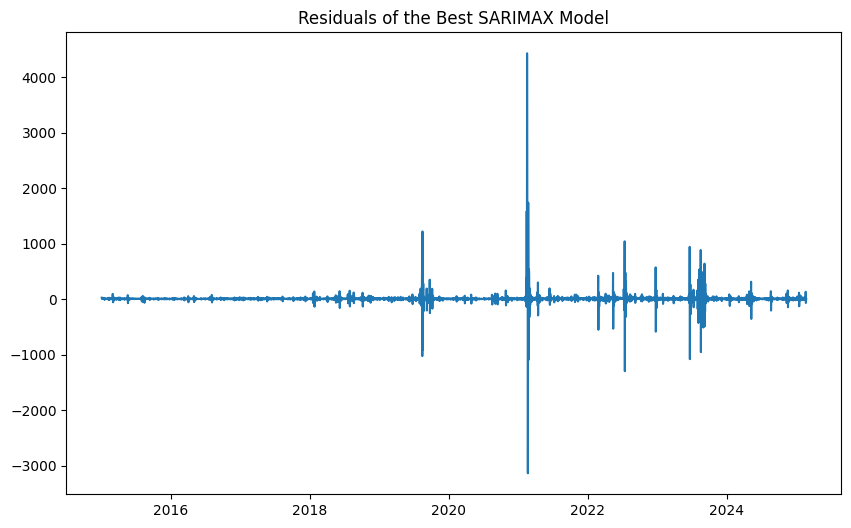

In [32]:
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of the Best SARIMAX Model')
plt.show()


Residuals of the SARIMA Model: The plot of residuals over time shows a stationary pattern with no 
clear trends or seasonality, which is kind of what I expected
However, noticeable spikes, particularly around 2021, suggest the model might not fully 
capture extreme market events, possibly due to external shocks like weather or policy changes impacting electricity
prices. These spikes highlight a limitation in the model's ability to handle outliers, suggesting a need for 
further investigation or model enhancement to improve robustness.

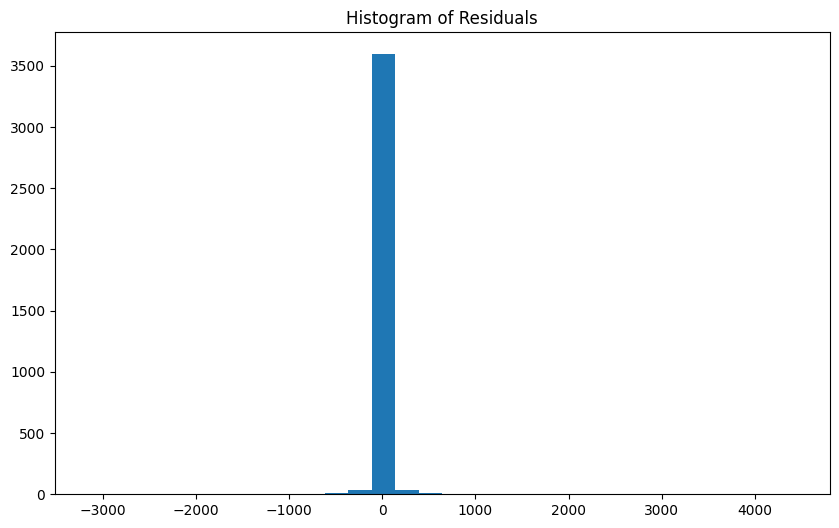

In [33]:
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.show()

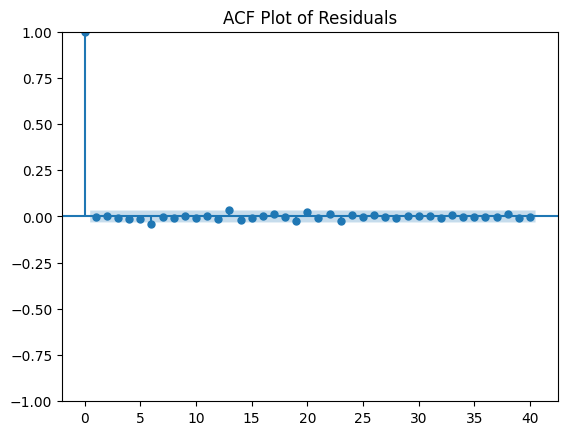

In [34]:
plot_acf(residuals, lags=40)
plt.title('ACF Plot of Residuals')
plt.show()

The ACF Plot of Residuals shows no significant autocorrelation beyond lag 0, 
with nearly all values falling within the confidence bounds, indicating that the residuals resemble white noise.

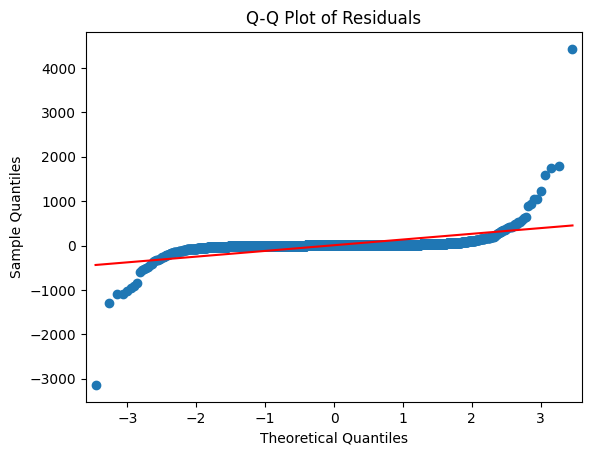

In [35]:
qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

The Q-Q Plot of Residuals shows that the residuals generally align with the theoretical normal distribution
 along the diagonal, particularly in the central range, suggesting that the models residuals are approximately
normally distributed for typical values. However, deviations at the tails, especially at the extremes, indicate
non-normality in the residuals, consistent with potential heavy-tailed behavior in the data. This suggests
that while the model fits well for the bulk of the data, it may not fully account for extreme 
price movements, potentially necessitating a model that better handles such distributions.

In [36]:
# Shapiro-Wilk test for normality
stat, p = shapiro(residuals)
print(f'Shapiro-Wilk Test: Statistic={stat}, p-value={p}')



Shapiro-Wilk Test: Statistic=0.1874088018463278, p-value=2.347368776196368e-83


2025-02-23   -10.628871
2025-02-24   -12.224608
2025-02-25    -6.652955
2025-02-26     1.896701
2025-02-27     1.446284
2025-02-28     1.648470
2025-03-01     1.004076
2025-03-02    -0.883817
2025-03-03    -0.747969
2025-03-04    -0.436385
2025-03-05    -0.243628
2025-03-06    -0.136014
Freq: D, Name: predicted_mean, dtype: float64


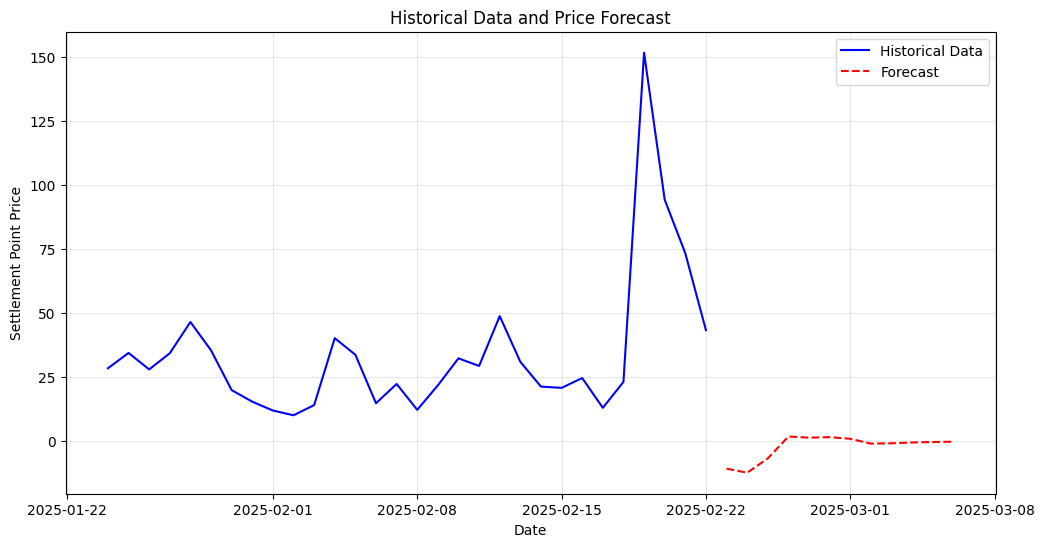

In [37]:
n_forecast = 12
forecast_values = best_results.forecast(steps=n_forecast)
print(forecast_values)
plt.figure(figsize=(12, 6))
historical_period = 30
historical_data = daily_data[-historical_period:]

plt.plot(historical_data.index, historical_data, label='Historical Data', color='blue')

forecast_dates = pd.date_range(start=historical_data.index[-1], 
                             periods=n_forecast + 1, 
                             freq='D')[1:] 

# Plot forecast
plt.plot(forecast_dates, forecast_values, label='Forecast', color='red', linestyle='--')
plt.title('Historical Data and Price Forecast')
plt.xlabel('Date')
plt.ylabel('Settlement Point Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Datetime
2015-01-01    25.211667
2015-01-02    24.488125
2015-01-03    22.963542
2015-01-04    21.648542
2015-01-05    20.929792
Freq: D, Name: Settlement Point Price, dtype: float64
Performance Metrics:
Mean Absolute Error: 37.68
Root Mean Squared Error: 85.43
Mean Absolute Percentage Errror: 99.63%


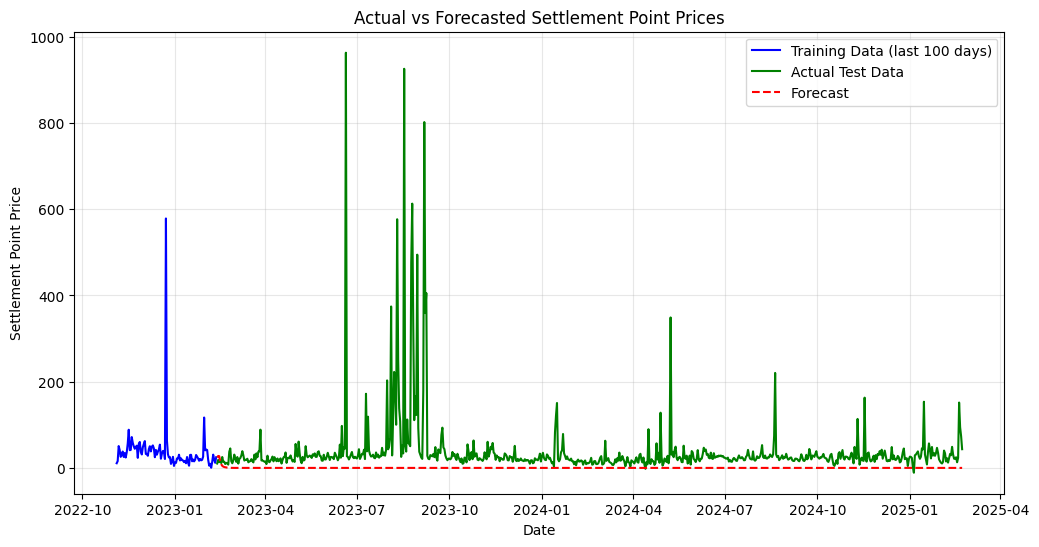

Performance Metrics:
Mean Absolute Error: 40.63
Root Mean Squared Error: 61.69
Mean Absolute Percentage Errror: nan%


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

daily_data
print(daily_data.head())


# Train-test split (80% train, 20% test)
train_size = int(len(daily_data)*0.8)
# Use all the data up till you get to 80% of the data for training
train_data = daily_data[:train_size]
# Everything after is test data
test_data = daily_data[train_size:]

best_order, best_seasonal_order = best_aic_model

historical_model = SARIMAX(train_data, order = best_order, seasonal_order = best_seasonal_order)
historical_results = historical_model.fit()

# Forecast for the test period

n_test = len(test_data)
forecast = historical_results.forecast(steps=n_test)

mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100  # MAPE in percentage

print(f"Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Errror: {mape:.2f}%")


plt.figure(figsize=(12, 6))
plt.plot(train_data.index[-100:], train_data[-100:], label='Training Data (last 100 days)', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('Actual vs Forecasted Settlement Point Prices')
plt.xlabel('Date')
plt.ylabel('Settlement Point Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


''' Let's redo the model so that we're only training it on about 2 weeks of historical data and then testing it on the two weeks following'''

# Create the training and testing data


c:\Users\mgray\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mgray\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\mgray\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performance Metrics:
Mean Absolute Error: 46.87
Root Mean Squared Error: 57.33
Mean Absolute Percentage Errror: 114.88%


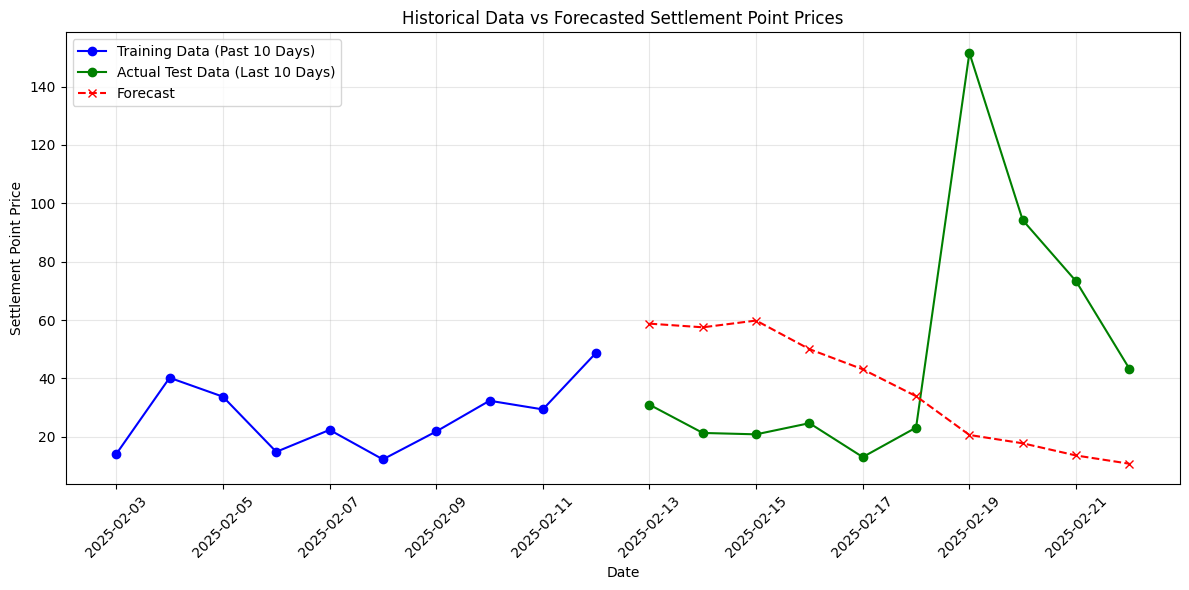

In [54]:
train_data = daily_data[-20:-10]
test_data = daily_data[-10:]

historical_model2 = SARIMAX(train_data, order = best_order, seasonal_order = best_seasonal_order)
historical_results2 = historical_model2.fit()


n_test = len(test_data)
forecast = historical_results2.forecast(steps=n_test)

mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100  # MAPE in percentage

print(f"Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Errror: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data (Past 10 Days)', color='blue', marker='o')
plt.plot(test_data.index, test_data, label='Actual Test Data (Last 10 Days)', color='green', marker='o')
plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--', marker='x')
plt.title('Historical Data vs Forecasted Settlement Point Prices')
plt.xlabel('Date')
plt.ylabel('Settlement Point Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
HB_NORTH_DATA['Datetime'] = pd.to_datetime(HB_NORTH_DATA['Delivery Date']) + pd.to_timedelta(HB_NORTH_DATA['Delivery Hour'] - 1, unit='h')
HB_NORTH_DATA.set_index('Datetime', inplace=True)

# Use hourly data directly (no daily resampling)
hourly_data = HB_NORTH_DATA['Settlement Point Price']

# Check data size and range
print(f"Total hours: {len(hourly_data)}")
print(f"Date range: {hourly_data.index[0]} to {hourly_data.index[-1]}")

# Train-test split: last 1 year for training, last 10 days (240 hours) for testing
train_data = hourly_data[-8760:-240]  # 365 days * 24 hours = 8760 hours
test_data = hourly_data[-240:]        # 10 days * 24 hours = 240 hours